In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def LCMA(A, L, extend_r=0.0):
    # returns indices according to path length, not total frames
    
    assert L < len(A)
    
    cumsum = np.cumsum(A)
    i0 = 0
    j0 = len(A)-1
    min_mean = (cumsum[j0] - cumsum[i0]) / (j0-i0)

    for i in range(len(cumsum)):
        for j in range(i+L,len(cumsum)):
            tmp_mean = (cumsum[j] - cumsum[i]) / (j-i)
            if tmp_mean < min_mean:
                min_mean = tmp_mean
                i0 = i
                j0 = j
    if extend_r > 0:
        extension = (j0-i0) * extend_r
        i0 = int(i0 - extension/2)
        j0 = int(j0 + extension/2)
        min_mean = (cumsum[j0] - cumsum[i0]) / (j0-i0)
    return i0, j0, min_mean

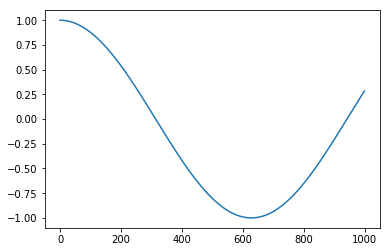

In [22]:
#A = np.random.rand(50)
A = np.cos(.1*np.linspace(0,50,num=1000))
plt.plot(A)

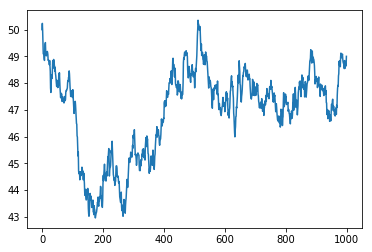

In [90]:
A = np.zeros_like(A)
A[0] = 50
for i in range(1,len(A)):
    A[i] = A[i-1] + 0.2*np.random.randn()
plt.plot(A)

In [4]:
L = 400

In [5]:
len(A)

1000

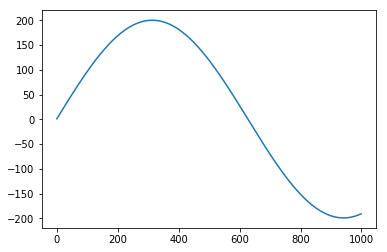

In [6]:
cumsum = np.cumsum(A)
plt.plot(cumsum)

In [7]:
len(cumsum)

1000

In [8]:
%timeit i0, j0, score = LCMA(A,L,0.1)

80.8 ms ± 815 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


NameError: name 'i0' is not defined

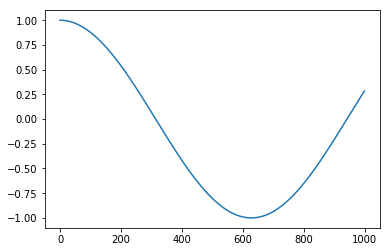

In [9]:
plt.plot(A)
plt.plot(range(i0,j0), A[i0:j0])

In [10]:
%load_ext cython

In [11]:
%%cython -a
import numpy as np
cimport numpy as np

def lcma_c(np.ndarray[np.double_t] A, int L, double extend_r=0.0):
    # returns indices according to path length, not total frames
    
    assert L < len(A)
    
    cdef double[:] cumsum = np.cumsum(A)
    cdef int i0 = 0
    cdef int j0 = len(A)-1
    cdef double min_mean = (cumsum[j0] - cumsum[i0]) / (j0-i0)

    cdef int i
    cdef int j
    
    
    for i in range(len(cumsum)):
        for j in range(i+L,len(cumsum)):
            tmp_mean = (cumsum[j] - cumsum[i]) / (j-i)
            if tmp_mean < min_mean:
                min_mean = tmp_mean
                i0 = i
                j0 = j
    if extend_r > 0:
        extension = (j0-i0) * extend_r
        i0 = int(i0 - extension/2)
        j0 = int(j0 + extension/2)
        min_mean = (cumsum[j0] - cumsum[i0]) / (j0-i0)
    return i0, j0, min_mean



In [12]:
%timeit i0, j0, score = lcma_c(A,L,0.1)

3.13 ms ± 36.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
from numba import jit, prange

In [289]:

@jit(nopython=True)
def LCMA_jit(A, L, extend_r=0.0, end_cut=0):
    # enc_cut: dont consider start and end of warp path

    cumsum = np.cumsum(A)
    i0 = 0
    j0 = len(cumsum) - 1
    min_mean = (cumsum[j0] - cumsum[i0]) / (j0 - i0)

    for i in range(end_cut,len(cumsum)-end_cut):
        for j in range(i + L, len(cumsum) -end_cut):
            tmp_mean = (cumsum[j] - cumsum[i]) / (j - i)
            if tmp_mean < min_mean:
                min_mean = tmp_mean
                i0 = i
                j0 = j

    if extend_r > 0:
        extension = (j0 - i0) * extend_r
        i0 = max(0, int(i0 - extension/2) )
        j0 = min(len(A)-1, int(j0 + extension/2) )
        min_mean = (cumsum[j0] - cumsum[i0]) / (j0 - i0)
    return i0, j0, min_mean



In [290]:
LCMA_jit(A,L,0.)


(108, 128, 0.47784173216988535)

In [297]:

@jit(nopython=True)
def LCMA_jit(A, L, extend_r=0.0, end_cut=0):
    # enc_cut: dont consider start and end of warp path

    cumsum = np.cumsum(A)
    i0 = 0
    j0 = len(cumsum) - 1
    min_mean = (cumsum[j0] - cumsum[i0]) / (j0 - i0)

    for i in range(end_cut,len(cumsum)-end_cut):
        for j in range(i + L, len(cumsum) -end_cut):
            tmp_mean = (cumsum[j] - cumsum[i]) / (j - i)
            if tmp_mean < min_mean:
                min_mean = tmp_mean
                i0 = i
                j0 = j

    extend_thr = min_mean*extend_r #min_mean * 1.01

    while (i0>0) and (A[i0] < extend_thr): i0 -=1
    while (j0<len(A)) and (A[j0] < extend_thr): j0 +=1
                
    return i0, j0, min_mean


In [298]:
%timeit i0, j0, score = LCMA_jit(A,L,0.1)

42.2 µs ± 9.03 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [293]:
LCMA_jit(A,L,0.1)


(108, 128, 0.47784173216988535)

In [299]:
@jit(nopython=True)
def lcma_numba_new(A, L, extend_r=1.0, end_cut=0):
    # returns indices according to path length, not total frames
    n = len(A)
    
    assert L < n
    
    i0 = 0
    j0 = n-1
    min_mean = np.sum(A[i0:j0]) / (j0-i0)

    for i in range(end_cut,n-end_cut):
        for j in range(i+L,n-end_cut):
            tmp_mean = np.sum(A[i:j]) / (j-i)
            if tmp_mean < min_mean:
                min_mean = tmp_mean
                i0 = i
                j0 = j

    extend_thr = min_mean*extend_r #min_mean * 1.01
    i_final = i0
    j_final = j0

    while (i_final>0) and (A[i_final] < extend_thr): i_final -=1
    while (j_final<len(A)) and (A[j_final] < extend_thr): j_final +=1
                
    return i_final, j_final, min_mean

In [303]:
%timeit i0, j0, score = lcma_numba_new(A,L,.0)

784 µs ± 41 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [301]:
lcma_numba_new(A,L,extend_r=1)

(108, 129, 0.47784173216988507)

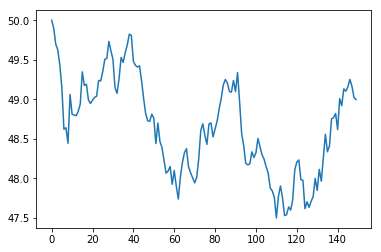

In [281]:
A = np.zeros(150)
A[0] = 50
for i in range(1,len(A)):
    A[i] = A[i-1] + 0.2*np.random.randn()
plt.plot(A)

In [282]:
L = 15
A /= 100

In [304]:
A[j0] - A[i0]

0.009630922952337528

In [305]:
    cumsum = np.cumsum(A)
    i0 = 0
    j0 = len(A)-1
    min_mean = sum(A[i0:j0]) / (j0-i0)

    for i in prange(len(A)):
        for j in prange(i+L,len(A)):
            tmp_mean = sum(A[i:j]) / (j-i)
            if tmp_mean < min_mean:
                min_mean = tmp_mean
                i0 = i
                j0 = j

In [257]:
min_mean, i0, j0, L

(0.4839080395871847, 62, 78, 15)

In [314]:
extend_thr = min_mean * 1.02
i_final = i0
j_final = j0

while (i_final>0) and (A[i_final] < extend_thr): i_final -=1
while (j_final<len(A)) and (A[j_final] < extend_thr): j_final +=1
    

Text(0, 0.5, 'Distortion')

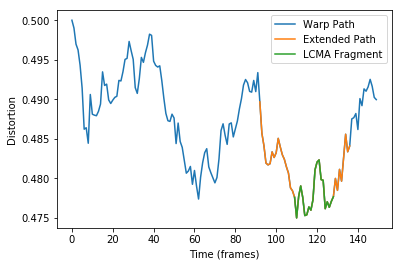

In [315]:
%matplotlib inline
plt.plot(A, label='Warp Path')
plt.plot(range(i_final,j_final),A[i_final:j_final], label='Extended Path')
plt.plot(range(i0,j0),A[i0:j0], label='LCMA Fragment')
plt.legend()
plt.xlabel('Time (frames)')
plt.ylabel('Distortion')


In [125]:
t = 0
sum(A[i0+t:j0+t]) / (j0-i0)

0.004781072047032997

In [251]:
A

array([0.5       , 0.49906494, 0.49584678, 0.49289632, 0.49554894,
       0.49529457, 0.49659184, 0.49881387, 0.49871978, 0.49999354,
       0.4999589 , 0.50040041, 0.50059749, 0.50229834, 0.49915993,
       0.49885751, 0.49956912, 0.49800758, 0.49413477, 0.49204112,
       0.49136588, 0.49129211, 0.49226443, 0.49522444, 0.4973468 ,
       0.49292255, 0.49291621, 0.48976102, 0.49044755, 0.49339572,
       0.49384053, 0.49142302, 0.49319768, 0.49389024, 0.492952  ,
       0.4933884 , 0.49293068, 0.49290528, 0.494579  , 0.49427933,
       0.49133807, 0.49094582, 0.49202337, 0.49106543, 0.49021652,
       0.49090145, 0.48799161, 0.49016513, 0.49279223, 0.49165002,
       0.49357821, 0.49548806, 0.49347751, 0.49477176, 0.49470995,
       0.49348074, 0.49471146, 0.49555667, 0.4946914 , 0.49445207,
       0.49324856, 0.49141173, 0.49043636, 0.48856924, 0.48743955,
       0.48411374, 0.48290399, 0.4845959 , 0.48703089, 0.48670392,
       0.48493452, 0.48463112, 0.48509934, 0.48273831, 0.47962